<a href="https://colab.research.google.com/github/martin-ramos/clasificador_de_imagenes_de_ropa/blob/main/RedNeuronalClasificadorDeImagenes(Ropa).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [56]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [57]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [58]:
datos_entrenamiento, datos_pruebas = datos['train'],datos['test']

In [59]:
nombres_clases = metadatos.features['label'].names

In [60]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [61]:
#### Normalizamos los datos (pasar de 0-255 a 0-1)
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 ## Se pasa de 0-255 a 0-1
  return imagenes, etiquetas

In [62]:
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)


In [63]:
### Agregamos a cache (usamos memoria en lugar de disco, se entrena mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

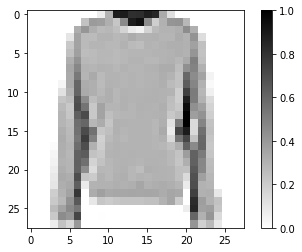

In [64]:
#### Mostremos una imagen de los datos de prueba
import matplotlib.pyplot as plt
for imagen, etiqueta in datos_entrenamiento.take(1) :
  break
imagen = imagen.numpy().reshape((28,28))

plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


In [65]:
### Crearemos el modelo 
## Flatten: es el tipo d capa, convierte la matriz y
## la aplasta a una dimension con 784 neuronas
## Dense: 2 capas ocultas con 50 neuronas cada una 
## con activación RELU
## Capa de salida: 10 neuronas con softmax
## Softmax se usa para clasificación como 
## funcion de activacion en la capa de salida

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28, 1)), #1 - Blanco y Negro  
    tf.keras.layers.Dense(50, activation=tf.nn.relu),                            
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) 
])

In [66]:
### Compilamos el modelo
modelo.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [67]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

num_ej_entrenamiento, num_ej_pruebas

(60000, 10000)

In [68]:
TAMANO_LOTE = 32
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [69]:
import math
### Entrenamos el modelo
historial = modelo.fit(datos_entrenamiento, epochs= 5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 12s 2ms/step - loss: 0.5160 - accuracy: 0.8197
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3826 - accuracy: 0.8618
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3514 - accuracy: 0.8703
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3247 - accuracy: 0.8818
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3128 - accuracy: 0.8845


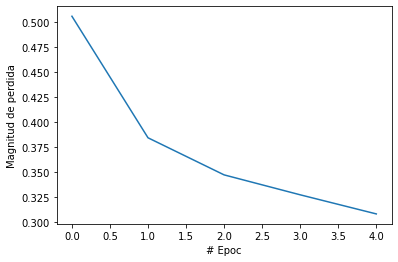

In [25]:
plt.xlabel("# Epoc")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

In [79]:
import numpy as np
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1) :
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes) :
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real :
    color = 'green'
  else :
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)



In [80]:
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('green')

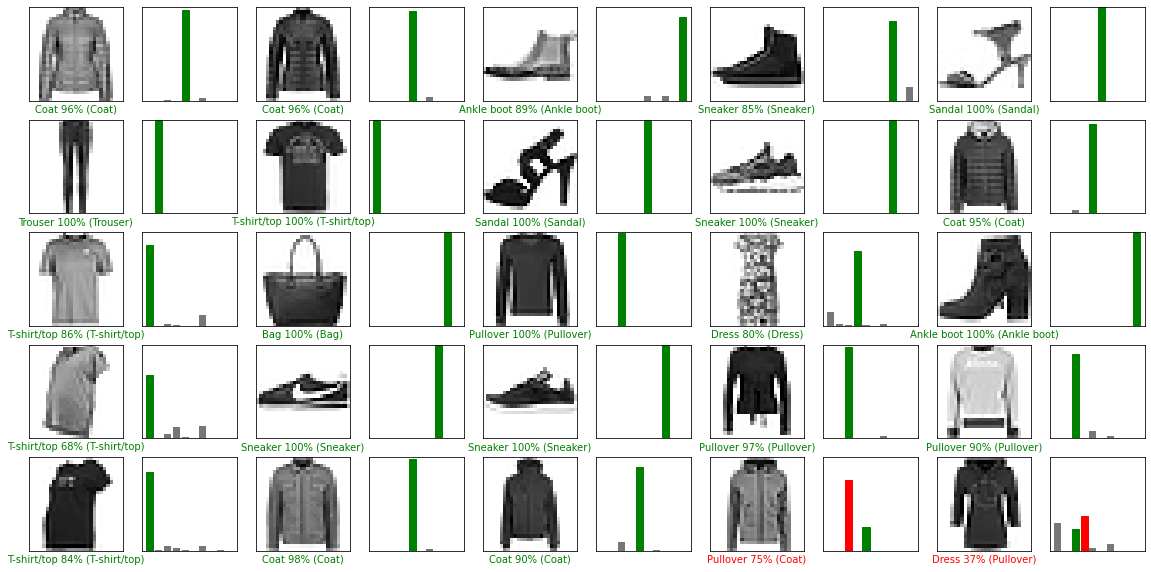

In [81]:
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [87]:
### Probamos una imagen aleatoria
imagen = imagenes_prueba[24]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])]) 

Prediccion: Dress
